In [1]:
# packages 
%pip install -q -U bitsandbytes
%pip install -q -U git+https://github.com/huggingface/transformers.git
%pip install -q -U git+https://github.com/huggingface/peft.git
%pip install -q -U git+https://github.com/huggingface/accelerate.git
%pip install -q -U datasets scipy ipywidgets matplotlib einops


You should consider upgrading via the '/Users/anshvijay/Desktop/hacklytics_project/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/anshvijay/Desktop/hacklytics_project/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/anshvijay/Desktop/hacklytics_project/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/anshvijay/Desktop/hacklytics_project/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/anshvijay/Desktop/hacklytics_project/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel 

## Accelerator

In [2]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

RuntimeError: There are currently no available devices found, must be one of 'XPU', 'CUDA', or 'NPU'.

## Load Datasets

In [12]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='train.json', split='train')
eval_dataset = load_dataset('json', data_files='val.json', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

### Formatting Prompt

In [13]:
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text

## Loading Base Model and Tokenizer

In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "microsoft/phi-2"

# bits_and_bytes_config = BitsAndBytesConfig(   quantization not working -_-
#     load_in_4bit=False,  
#     load_in_8bit=True
# )

model = AutoModelForCausalLM.from_pretrained(
    base_model_id, 
    trust_remote_code=True, 
    torch_dtype=torch.float32,
)

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)
tokenizer.pad_token = tokenizer.eos_token 

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
# convert datasets with tokenizer

tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

#### Obtaining best max_length hyperparameter 

100


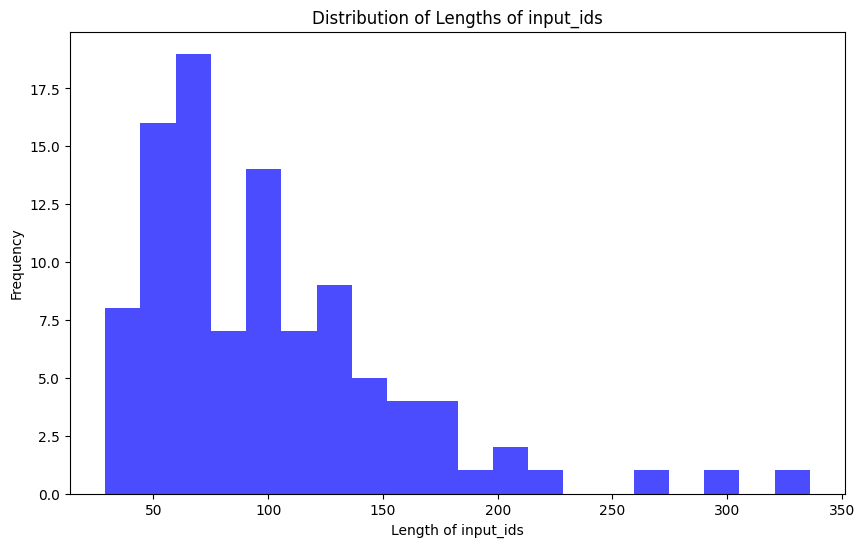

In [16]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [17]:
max_length = 512 # By inspection we determine this to be the best max_length

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [18]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

#### We should expect eos padding at the beginning and end

In [19]:
print(tokenized_train_dataset[1]['input_ids'])

[50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256

### All data points should be the same length now

100


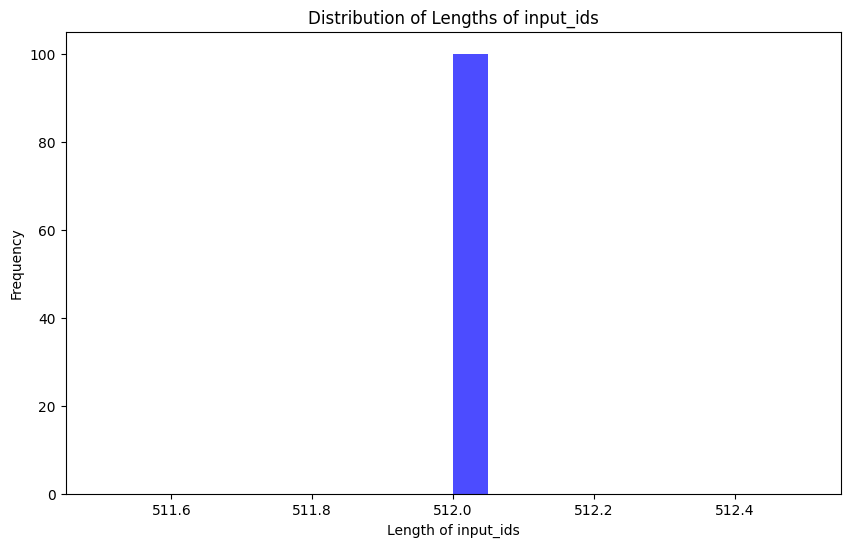

In [20]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

## Test Base Model (with a set max_length)

In [23]:
eval_prompt = "Write the DFS search algorithm for a 2D list of elements consisting of '1' and '0"
# Init an eval tokenizer so it doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt") #.to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


KeyboardInterrupt: 